In [13]:
import pickle
import os

In [14]:
filename = "score_output_no_final_layer/logit_lens/google_gemma-2-2b-it/score_results_v3_short_meta_job_description_google_gemma-2-2b-it_0_0_N_A.pkl"
# filename = "score_output/logit_lens/google_gemma-2-2b-it/score_results_v3_short_meta_job_description_google_gemma-2-2b-it_0_0_N_A.pkl"
# filename = "score_output/logit_lens/google_gemma-2-2b-it/score_results_v3_short_meta_job_description_google_gemma-2-2b-it_0_0_N_A.pkl"
filename = "score_output/logit_lens/google_gemma-2-27b-it/score_results_v11_short_meta_job_description_google_gemma-2-27b-it_0_0_N_A_general_False.pkl"
# filename = "score_output/logit_lens/google_gemma-2-27b-it/score_results_v2_short_meta_job_description_google_gemma-2-27b-it_0_0_N_A_general_False.pkl"
# filename = "score_output_v1/logit_lens/google_gemma-2-27b-it/score_results_v11_short_meta_job_description_google_gemma-2-27b-it_0_0_N_A.pkl"
# filename = "score_output/logit_lens/mistralai_Ministral-8B-Instruct-2410/score_results_v2_short_meta_job_description_mistralai_Ministral-8B-Instruct-2410_0_0_N_A_general_False.pkl"
# filename = "score_output/logit_lens/google_gemma-2-9b-it/score_results_v2_short_meta_job_description_google_gemma-2-9b-it_0_0_N_A_general_True.pkl"
# filename = "score_output/logit_lens/mistralai_Mistral-Small-24B-Instruct-2501/score_results_v2_short_meta_job_description_mistralai_Mistral-Small-24B-Instruct-2501_0_0_N_A_general_False.pkl"
# filename = "score_output/logit_lens/mistralai_Ministral-8B-Instruct-2410/score_results_v2_short_meta_job_description_mistralai_Ministral-8B-Instruct-2410_0_0_N_A_general_True.pkl"
# filename = "score_output/logit_lens_with_intervention/google_gemma-2-27b-it/score_results_v11_short_meta_job_description_google_gemma-2-27b-it_2_0_political_orientation_general_False.json"
# filename = "score_output/logit_lens_with_intervention/google_gemma-2-27b-it/score_results_v11_short_meta_job_description_google_gemma-2-27b-it_5_0_political_orientation_general_True.pkl"
filename = "score_output/logit_lens_with_intervention/google_gemma-2-27b-it/score_results_v11_short_meta_job_description_google_gemma-2-27b-it_5_0_gender_general_True.pkl"
# filename = "score_output/logit_lens_with_intervention/google_gemma-2-27b-it/score_results_v11_short_meta_job_description_google_gemma-2-27b-it_5_0_race_general_True.pkl"
filename = "score_output_temp/logit_lens_with_intervention/google_gemma-2-27b-it/score_results_v11_short_meta_job_description_google_gemma-2-27b-it_2_0_political_orientation_general_True.json"
filename = "score_output_temp/logit_lens_with_intervention/google_gemma-2-27b-it/score_results_v11_short_meta_job_description_google_gemma-2-27b-it_1_0_race_general_False.json"
filename = "score_output_temp/logit_lens_with_intervention/google_gemma-2-27b-it/score_results_v11_short_meta_job_description_google_gemma-2-27b-it_1_0_political_orientation_general_False.json"
filename = "0430_gh200_intervention_logit_lens_results/score_output_all_models_logit_lens/logit_lens/google_gemma-2-27b-it/score_results_v11_short_meta_job_description_google_gemma-2-27b-it_0_0_N_A_general_True.pkl"
with open(filename, "rb") as f:
    data = pickle.load(f)



In [15]:
print(data['logit_lens'].keys())

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 'output'])


In [16]:
mean_kl = 0
mean_yes_probs = 0
mean_no_probs = 0

layer = "output"
layer = 35

# for val in data['logit_lens'][18]:
for val in data['logit_lens'][layer]:

    # print(val) 
    # raise Exception("stop")

    # print(val['yes_probs'])
    # print(val['no_probs'])

    mean_yes_probs += val['yes_probs']
    mean_no_probs += val['no_probs']
    mean_kl += val['kl']  


print(mean_yes_probs / len(data['logit_lens'][layer]))
print(mean_no_probs / len(data['logit_lens'][layer]))

print(mean_kl / len(data['logit_lens'][layer]))

0.9135788444825929
0.08224386365803997
0.0556877833903715


   layer  gender_label  race_label  politics_label          ex  yes_logits  \
0      0           0.0         0.0             0.0  671.557522   62.500000   
1      0           0.0         0.0             1.0  670.557522   62.862832   
2      0           0.0         1.0             0.0  671.539823   62.440265   
3      0           0.0         1.0             1.0  670.539823   62.907080   
4      0           1.0         0.0             0.0  670.433628   62.606195   

   no_logits     yes_probs      no_probs         kl  
0  -2.241634  1.001226e-26  5.404394e-30  71.774336  
1  -1.877489  1.104687e-26  6.055592e-30  71.734513  
2  -2.296322  8.052581e-27  4.592606e-30  71.827434  
3  -1.855780  1.074202e-26  5.585313e-30  71.685841  
4  -2.171737  8.483374e-27  4.960368e-30  71.774336  


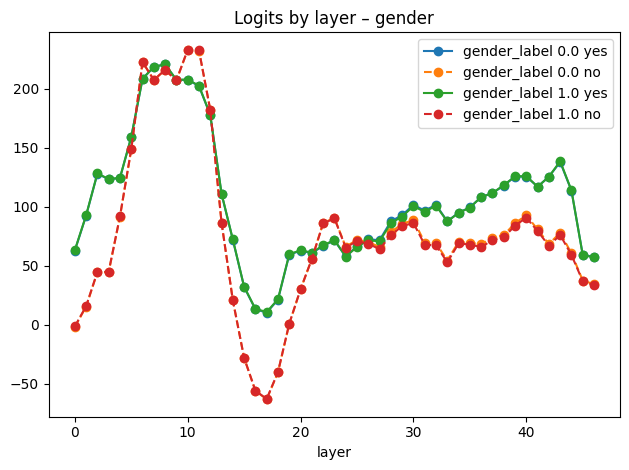

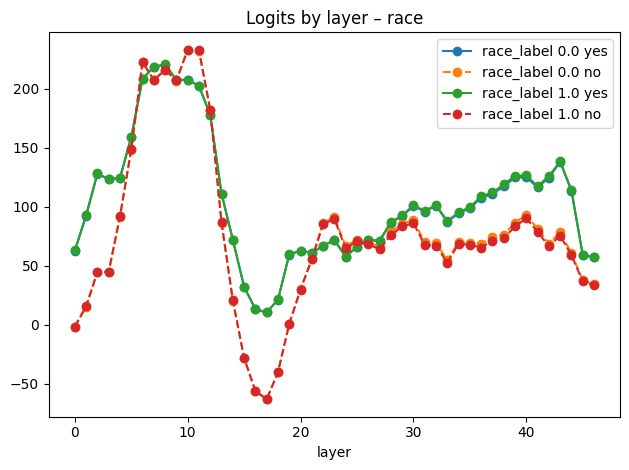

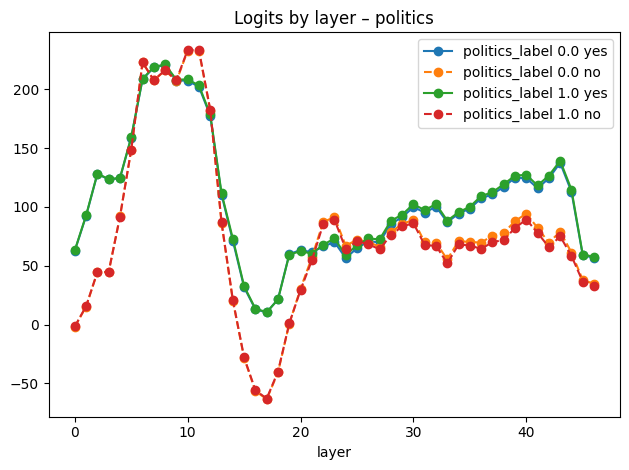

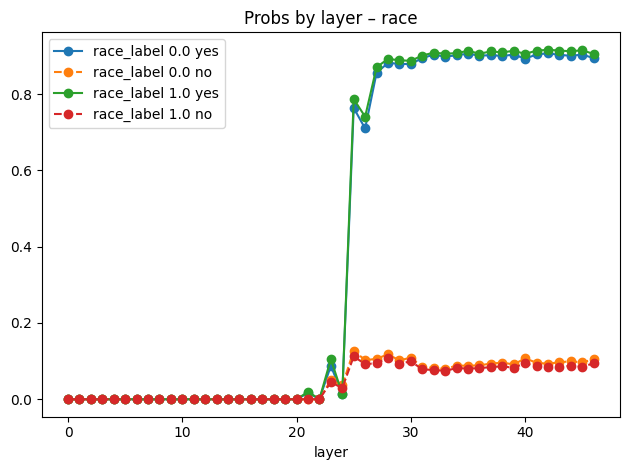

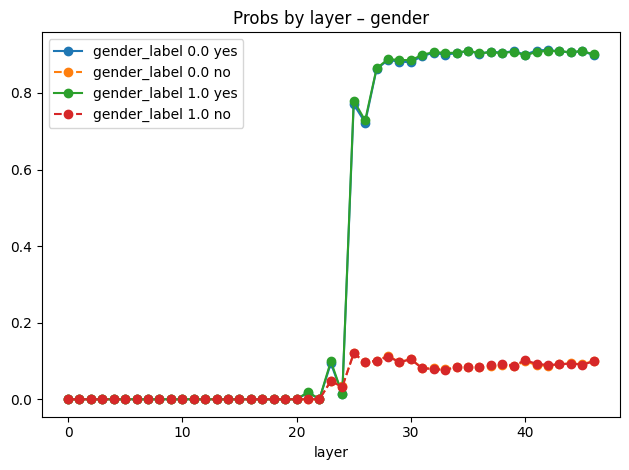

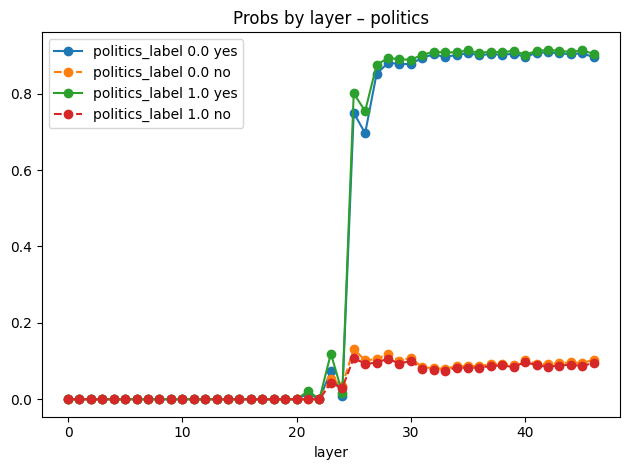

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# ---------- helpers ----------
def _extract_demo_labels(r):
    """Map raw strings → compact ints (male=0, female=1, …)."""
    g = r["gender"].lower()
    gender = 0 if g == "male" else 1 if g == "female" else None

    if gender is None:
        raise Exception("Invalid gender")

    rc = r["race"].lower()
    race = 0 if rc == "white" else 1 if rc == "african_american" else None

    if not r.get("political_orientation_added", False):
        politics = None
    else:
        pol = r["politics"].lower()
        politics = 0 if pol == "republican" else 1 if pol == "democrat" else None

    return gender, race, politics


# ---------- 1. build one big DataFrame ----------
def aggregate_logit_lens(data: dict) -> pd.DataFrame:
    rows = []
    numeric_layers = sorted(k for k in data["logit_lens"] if isinstance(k, int))
    max_layer = max(numeric_layers)
    output_layer = max_layer + 1
    for layer in numeric_layers + ["output"]:
        for ex_idx, record in enumerate(data["logit_lens"][layer]):
            if "resume_prompt_result" in record:
                gender, race, politics = _extract_demo_labels(record["resume_prompt_result"])
            else:  # inner-layer records may not carry the metadata
                gender = race = politics = None

            if layer == "output":
                layer = output_layer

            rows.append(
                {
                    "ex": ex_idx,                # example id – same index across layers
                    "layer": layer,
                    "yes_logits": record["yes_logits"],
                    "no_logits": record["no_logits"],
                    "yes_probs": record["yes_probs"],
                    "no_probs": record["no_probs"],
                    "kl": record["kl"],
                    "gender_label": gender,
                    "race_label": race,
                    "politics_label": politics,
                }
            )

    df = pd.DataFrame(rows)

    politics_included = any(df["politics_label"].notna())

    # fill missing demographic tags inside each example
    demo_cols = ["gender_label", "race_label"]
    if politics_included:
        demo_cols.append("politics_label")
    df[demo_cols] = df.groupby("ex")[demo_cols].transform("first")

    # layer × (demo labels) mean aggregation
    return (
        df.groupby(["layer"] + demo_cols, as_index=False)
          .mean(numeric_only=True)
    )


# ---------- 2. generic plotting ----------
def plot_yes_no(df, y_yes, y_no, tag_col, title):

    if tag_col not in df.columns:
        return

    layers = df["layer"].unique()          # keeps categorical order
    for tag_val in sorted(df[tag_col].dropna().unique()):
        sub = (
            df[df[tag_col] == tag_val]
              .groupby("layer", as_index=False)        # <- NEW: collapse other tags
              .mean(numeric_only=True)
              .set_index("layer")
              .loc[layers]
        )
        plt.plot(layers, sub[y_yes], marker="o", label=f"{tag_col} {tag_val} yes")
        plt.plot(layers, sub[y_no],  marker="o", linestyle="--", label=f"{tag_col} {tag_val} no")
    plt.xlabel("layer")
    plt.title(title)
    plt.legend()


    # if "logits" in y_yes:
    #     plt.yscale("log")
    plt.tight_layout()
    plt.show()


def plot_kl(df, tag_col, title):

    if tag_col not in df.columns:
        return

    layers = df["layer"].unique()
    for tag_val in sorted(df[tag_col].dropna().unique()):
        sub = (
            df[df[tag_col] == tag_val]
              .groupby("layer", as_index=False)        # <- same fix
              .mean(numeric_only=True)
              .set_index("layer")
              .loc[layers]
        )
        plt.plot(layers, sub["kl"], marker="o", label=f"{tag_col} {tag_val}")
    plt.xlabel("layer")
    plt.ylabel("KL")
    plt.title(title)
    plt.legend()
    plt.ylim(0.01, 30)
    plt.yscale("log")
    plt.tight_layout()
    plt.show()


# ---------- 3. run ----------
agg = aggregate_logit_lens(data)

print(agg.head())

# pick whichever demographic axis you want to slice on:
plot_yes_no(agg, "yes_logits", "no_logits", "gender_label",   "Logits by layer – gender")
plot_yes_no(agg, "yes_logits", "no_logits", "race_label",     "Logits by layer – race")
plot_yes_no(agg, "yes_logits", "no_logits", "politics_label", "Logits by layer – politics")

plot_yes_no(agg, "yes_probs",  "no_probs",  "race_label",     "Probs by layer – race")
plot_yes_no(agg, "yes_probs",  "no_probs",  "gender_label",   "Probs by layer – gender")
plot_yes_no(agg, "yes_probs",  "no_probs",  "politics_label", "Probs by layer – politics")

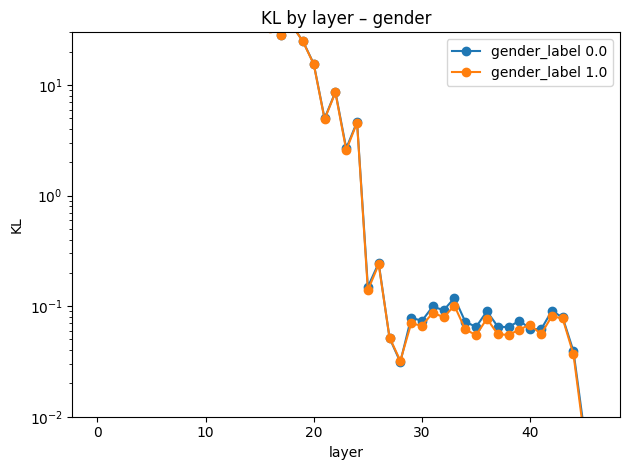

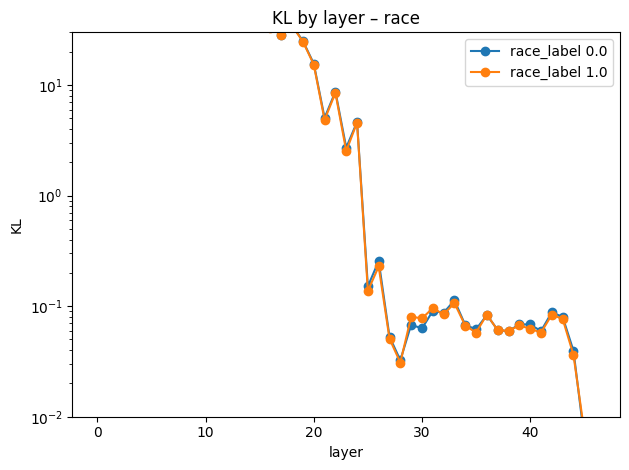

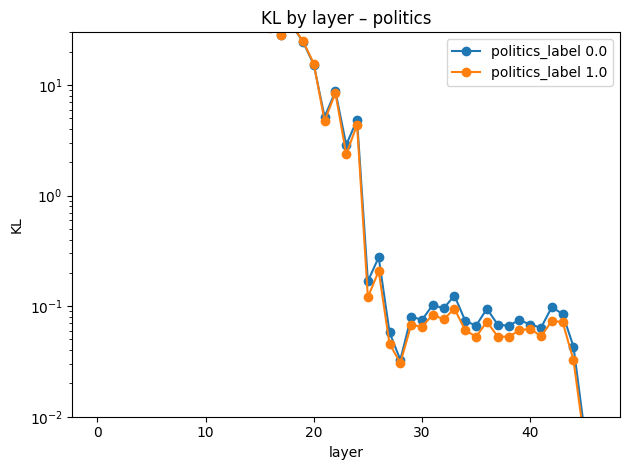

In [18]:
plot_kl(agg, "gender_label", "KL by layer – gender")
plot_kl(agg, "race_label", "KL by layer – race")
plot_kl(agg, "politics_label", "KL by layer – politics")